In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]='PCI_BUS_ID'
os.environ["CUDA_VISIBLE_DEVICES"]='3'

In [2]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

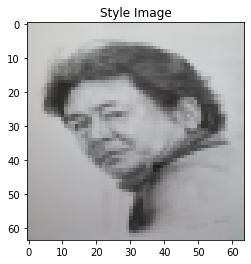

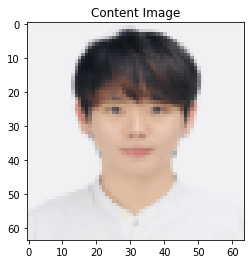

In [3]:
imsize = 2**6

loader = transforms.Compose([
    transforms.Resize((imsize, imsize)), 
    transforms.ToTensor()])

def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

style_img = image_loader("./style_human_3.jpg")
content_img = image_loader("./content_human_1.jpg")

assert style_img.size() == content_img.size(), "we need to import style and content images of the same size"


unloader = transforms.ToPILImage()
plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    plt.imshow(image)
    if title is not None: plt.title(title)
    plt.pause(0.001)

plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

In [4]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input


def gram_matrix(input):
    
    a, b, c, d = input.size()
    features = input.view(a * b, c * d)
    G = torch.mm(features, features.t())
    return G.div(a * b * c * d)


class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

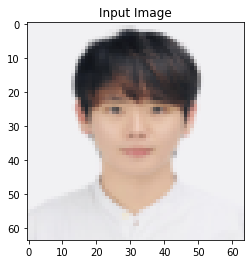

In [5]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)


class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std


content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)
    normalization = Normalization(normalization_mean, normalization_std).to(device)
    content_losses = []
    style_losses = []

    model = nn.Sequential(normalization)

    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

input_img = content_img.clone()

plt.figure()
imshow(input_img, title='Input Image')

Building the style transfer model..


/home/kbdlab-server2/anaconda3/envs/jason/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]
/home/kbdlab-server2/anaconda3/envs/jason/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


Optimizing..
run [50]:
Style Loss : 149.869476 Content Loss: 13.231256


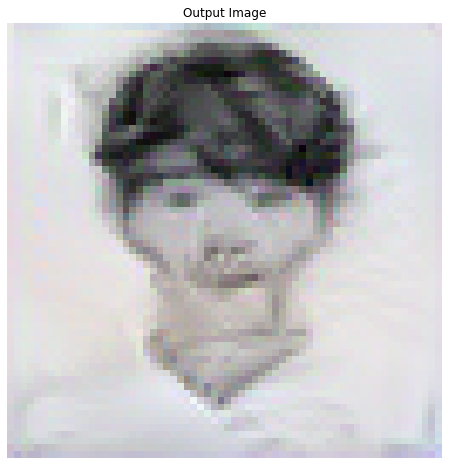


run [100]:
Style Loss : 46.849812 Content Loss: 14.543800


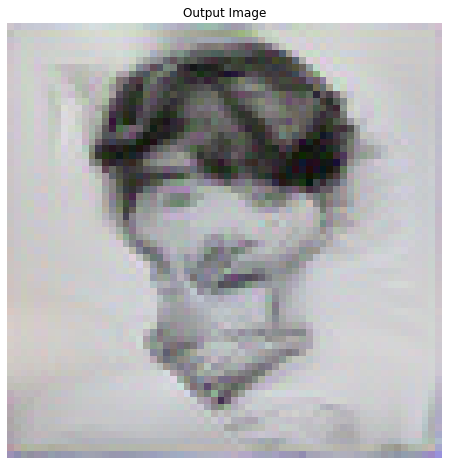


run [150]:
Style Loss : 24.549580 Content Loss: 14.481369


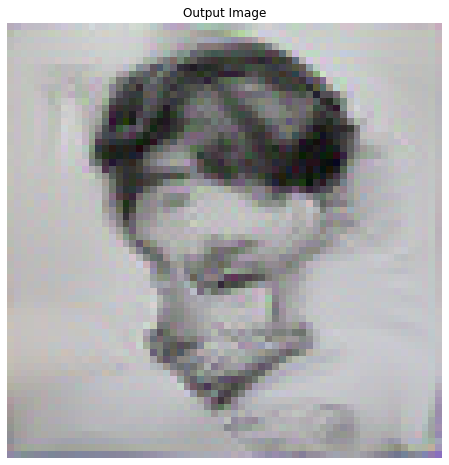


run [200]:
Style Loss : 18.190828 Content Loss: 14.156834


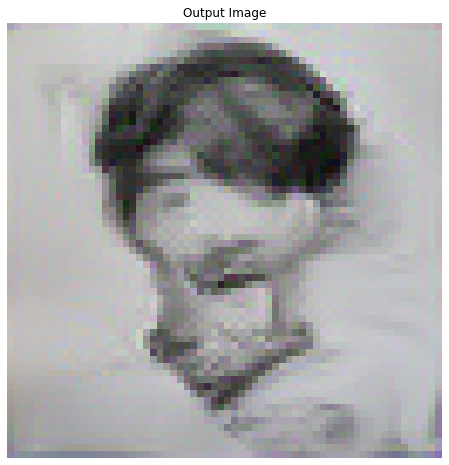


run [250]:
Style Loss : 15.390161 Content Loss: 14.084084


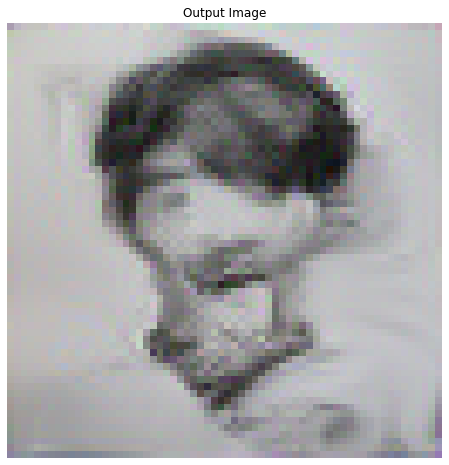


run [300]:
Style Loss : 13.808116 Content Loss: 14.047363


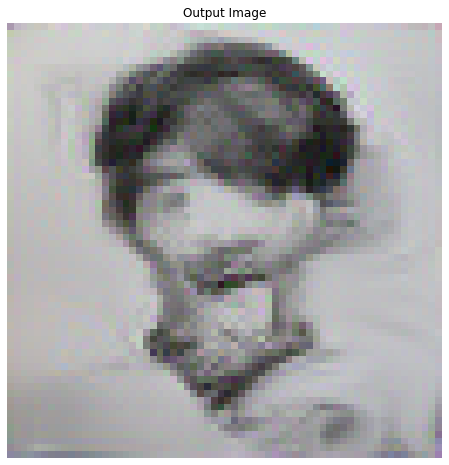


run [350]:
Style Loss : 12.885750 Content Loss: 14.022213


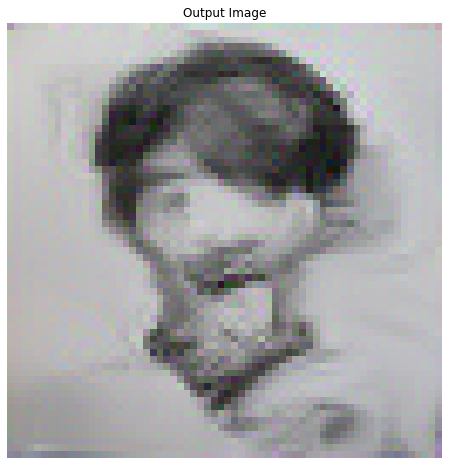


run [400]:
Style Loss : 12.377707 Content Loss: 13.937215


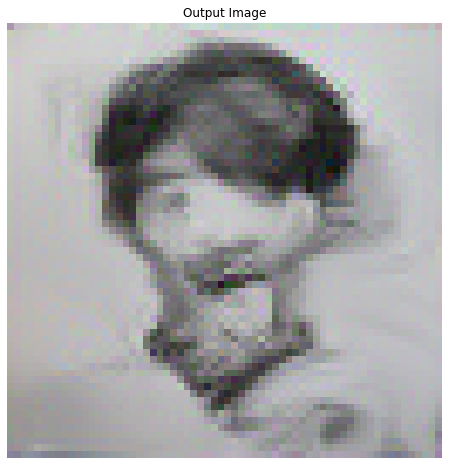


run [450]:
Style Loss : 12.021143 Content Loss: 13.894485


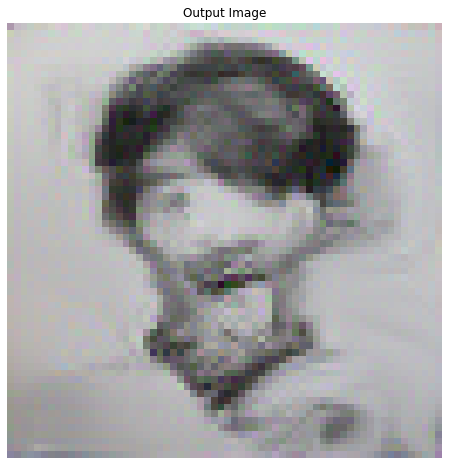


run [500]:
Style Loss : 11.657914 Content Loss: 13.900743


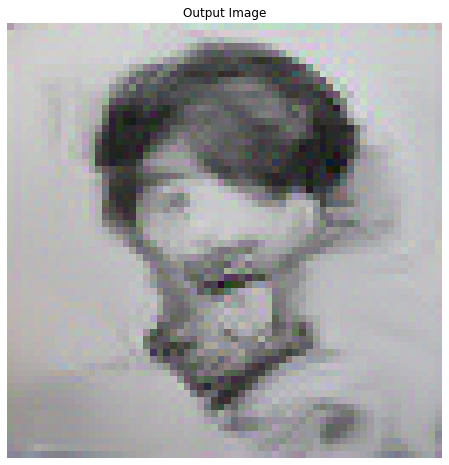


run [550]:
Style Loss : 11.424493 Content Loss: 13.901808


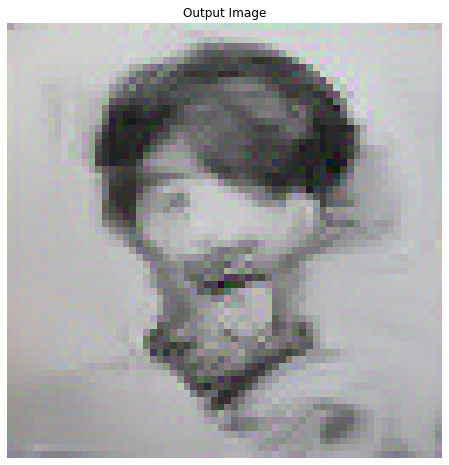


run [600]:
Style Loss : 11.256048 Content Loss: 13.914246


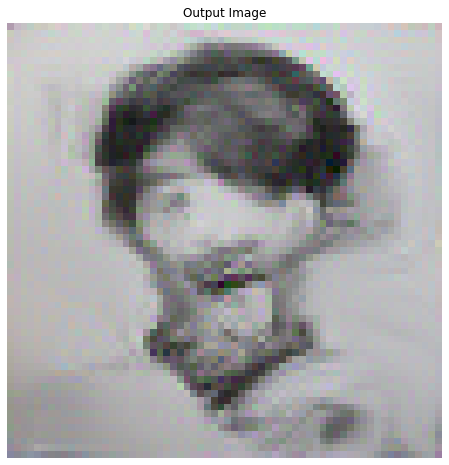


run [650]:
Style Loss : 11.116096 Content Loss: 13.930312


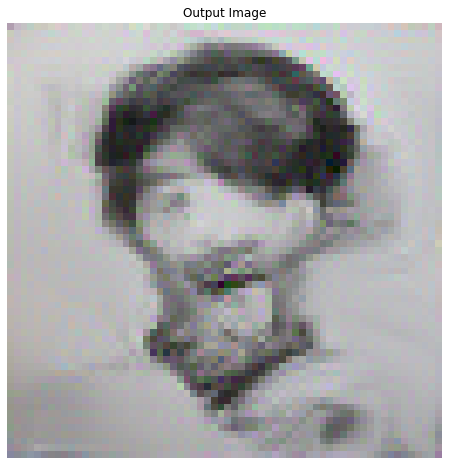


run [700]:
Style Loss : 10.999413 Content Loss: 13.934856


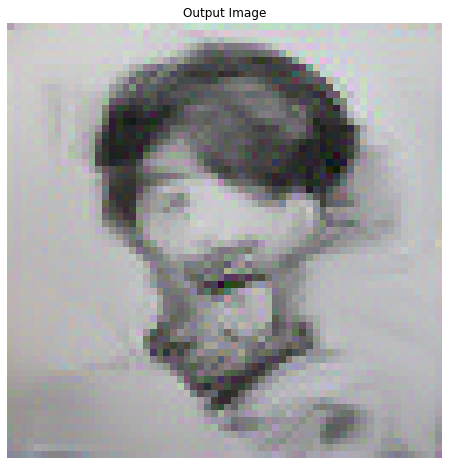


run [750]:
Style Loss : 10.882360 Content Loss: 13.949566


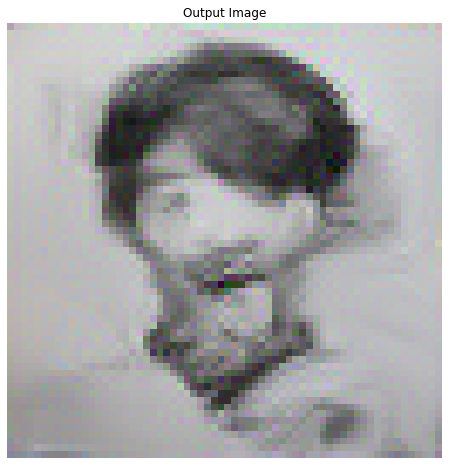


run [800]:
Style Loss : 10.769027 Content Loss: 13.961102


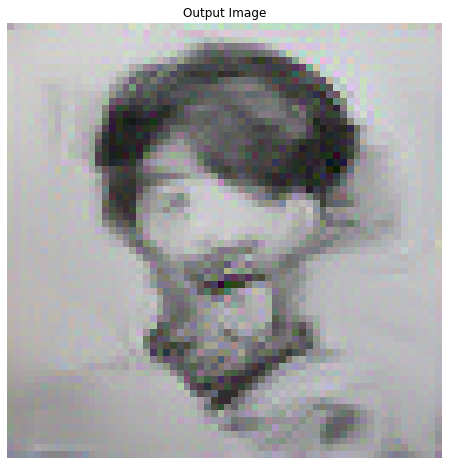


run [850]:
Style Loss : 10.694296 Content Loss: 13.961517


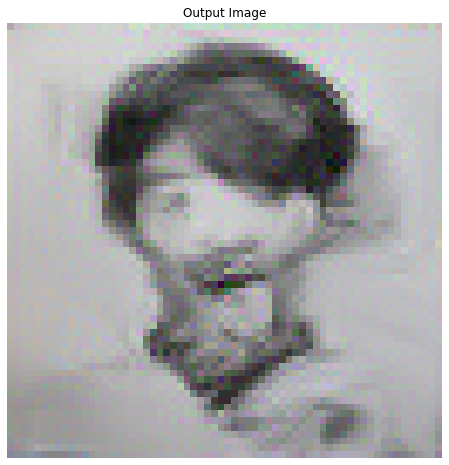


run [900]:
Style Loss : 10.629890 Content Loss: 13.958166


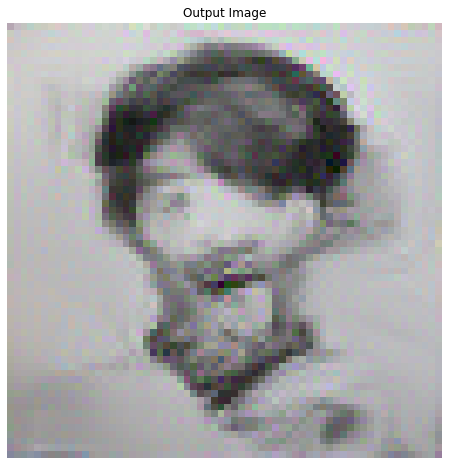


run [950]:
Style Loss : 10.582347 Content Loss: 13.952263


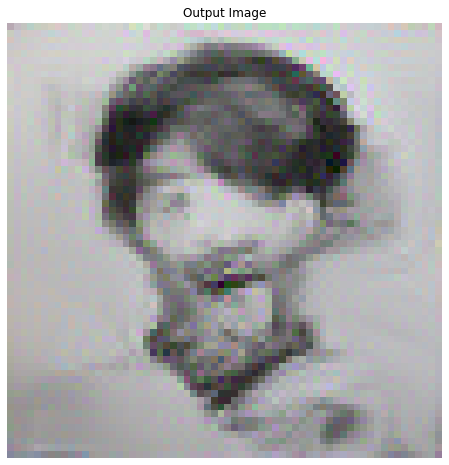


run [1000]:
Style Loss : 10.542715 Content Loss: 13.951046


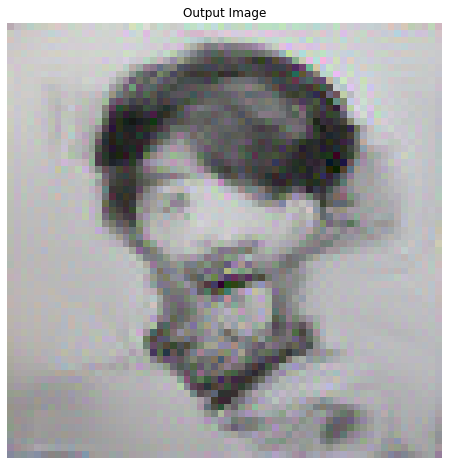


[50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000]
[149.86947631835938, 46.84981155395508, 24.549579620361328, 18.190828323364258, 15.39016056060791, 13.80811595916748, 12.885749816894531, 12.377706527709961, 12.021142959594727, 11.657914161682129, 11.424492835998535, 11.256048202514648, 11.116096496582031, 10.999412536621094, 10.882360458374023, 10.769026756286621, 10.694295883178711, 10.629890441894531, 10.58234691619873, 10.542715072631836]
[13.231255531311035, 14.543800354003906, 14.481369018554688, 14.15683364868164, 14.084083557128906, 14.04736328125, 14.022212982177734, 13.937214851379395, 13.894485473632812, 13.90074348449707, 13.90180778503418, 13.91424560546875, 13.930312156677246, 13.934856414794922, 13.949565887451172, 13.961101531982422, 13.961517333984375, 13.958166122436523, 13.952262878417969, 13.951045989990234]


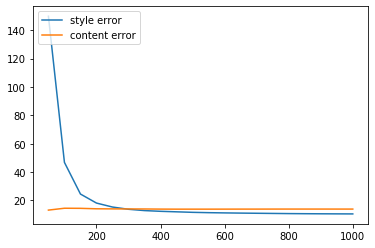

In [6]:
def get_input_optimizer(input_img):

    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=1000,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn, normalization_mean, 
                                                                     normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    step = []
    style_error = []
    content_error = []
    
    while run[0] <= num_steps:

        def closure():
            
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                plt.figure(figsize=(8,8))
                plt.axis('off')
                imshow(input_img, title='Output Image')
                plt.ioff()
                plt.show()
                print()
                step.append(run[0])
                style_error.append(style_score.item())
                content_error.append(content_score.item())

            return style_score + content_score

        optimizer.step(closure)

    input_img.data.clamp_(0, 1)
    
    return step, style_error, content_error



step, style_error, content_error = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                                                        content_img, style_img, input_img)

print(step)
print(style_error)
print(content_error)
plt.plot(step, style_error, label='style error')
plt.plot(step, content_error, label='content error')

plt.legend(loc='upper left')
plt.show()